
In this notebook, we aim to forecast a system's behavior with partial information. We'll establish the equations of motion for a straightforward double pendulum (or perhaps it should be called a double simple pendulum). Subsequently, we'll explore whether a machine learning approach can accurately predict the forthcoming position of the lower mass solely based on its own positions.

# From Notes

#### Positions
$$x_1 = L_1 \sin \theta_1$$
$$y_1 = -L_1 \cos \theta_1$$
$$x_2 = x_1 + L_2 \sin \theta_2$$
$$y_2 = y_1 - L_2 \cos \theta_2$$

#### Velocities
$$\dot{x}_1 = \dot{\theta_1} L_1 \cos \theta_1$$
$$\dot{y_1} =  \dot{\theta_1} L_1 \sin \theta_1$$
$$\dot{x_2} = \dot{x_1} + \dot{\theta_2} L_2 \cos \theta_2$$
$$\dot{y_2} = \dot{y_1} + \dot{\theta_2} L_2 \sin \theta_2$$


#### Accelerations

$$\ddot{x}_1 = -\dot{\theta_1}^2 L_1 \sin \theta_1 + \ddot{\theta_1} L_1 \cos \theta_1$$
$$\ddot{y_1} =  \dot{\theta_1}^2 L_1 \cos \theta_1 + \ddot{\theta_1} L_1 \sin \theta_1$$
$$\ddot{x_2} = \ddot{x_1} - \dot{\theta_2}^2 L_2 \sin \theta_2 + \ddot{\theta_2} L_2 \cos \theta_2$$
$$\ddot{y_2} = \ddot{y_1} + \dot{\theta_2}^2 L_2 \cos \theta_2 + \ddot{\theta_2} L_2 \sin \theta_2$$

#### Energies
Let $v_1^2 = \dot{x_1}^2 +\dot{y_1}^2$ and $v_2^2 = \dot{x_2}^2 +\dot{y_2}^2$ then the kinetic energies $T_1$ and $T_2$ are
$$ T_1 = \frac{1}{2}m_1 v_1^2 = \frac{1}{2}m_1 L_1^2 \dot{\theta_1}^2 $$
$$ T_2 = \frac{1}{2}m_2 v_2^2 = \frac{1}{2}m_2 \left( L_1^2 \dot{\theta_1}^2 + L_2^2 \dot{\theta_2}^2 + 2L_1 L_2 \cos(\theta_1-\theta_2) \dot{\theta_1} \dot{\theta_2} \right) $$

The potential enrgies are
$$V_1 = m_1 g y_1 = - m_1 g L_1 \cos \theta_1$$
$$V_2 = m_2 g y_2 = -m_2 g ( L_1 \cos \theta_1 + L_2 \cos \theta_2)$$

#### Langrangian
Now we form the Lagrangian $L=T-V=T_1+T_2 -V_1 -V_2$ and use the Euler-Lagrange equations:
$$\frac{\partial L}{\partial \theta_1} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}}$$
$$\frac{\partial L}{\partial \theta_2} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}}$$

Applying these gives
$$-(m_1+m_2) g L_1 \sin \theta_1 = (m_1+m_2) L_1^2 \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_2}^2 +  m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_2} $$
and
$$ -m_2 g L_2 \sin \theta_2 = m_2 L_2 \ddot{\theta_2} + m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_1}^2 $$ 


#### Equations of motions
$$ \omega_1 = \dot{\theta_1}$$  

$$ \omega_2 = \dot{\theta_2}$$ 
$$ \ddot\theta_1 = \frac{1}{L_1\xi}\left[L_1m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_1^2 + L_2m_2\sin(\theta_1-\theta_2)\omega_2^2 - m_2g\cos(\theta_1-\theta_2)\sin(\theta_2) + (m_1+m_2)g\sin(\theta_1) \right] $$
$$ \ddot\theta_2 = \frac{1}{L_2\xi}\left[L_2m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_2^2 + L_1(m_1+m_2)\sin(\theta_1-\theta_2)\omega_1^2+(m_1+m_2)g\sin(\theta_1)\cos(\theta_1-\theta_2) - (m_1+m_2)g\sin(\theta_2) \right] $$
where 
$$\xi \equiv \cos^2(\theta_1-\theta_2)m_2-m_1-m_2$$


In [2]:
#importing libraries
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp

import matplotlib.style 
import matplotlib as mpl 

import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from scipy import linalg

#formatting
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 



2024-03-16 12:35:49.544338: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Pre-defined Functions

Functions provided from course notes

In [3]:
def rhs(t, z, L1, L2, m1, m2, g):
    """
    Returns the right-hand side of the ordinary differential equation describing the double pendulem
    """
    theta1, w1, theta2, w2 = z    #The four components
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)
    return w1, w1dot, w2, w2dot   #Return the w's and the wdot's


def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """ Transforms theta and omega to cartesian coordinates
    and velocities x1, y1, x2, y2, vx1, vy1, vx2, vy2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2
    

### Initial parameters

In [4]:
#lengths, masses and gravity constant
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     

#starting position
z0=[np.pi/4,0,np.pi/4,0]

#time steps and max time
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)



In [5]:
def Solve_Actual(tmax, z0, t, L1, L2, m1, m2):
    """
    Solves the differential equations of a double pendulum system using numerical integration.

    Parameters:
        tmax: The maximum time limit
        z0: Initial conditions for the pendulum system
        t: Time points at which to evaluate the solution
        L1: Length of the first pendulum arm
        L2: length of the second pendulum arm
        m1: mass of the first pendulum
        m2: Mass of the second pendulum

    Returns:
        x1, y1, x2, y2: Cartesian coordinates of the two pendulum masses.
    """
    g = 9.81
    
    #solve the initial value problem for the differential equations
    ret = solve_ivp(rhs, (0, tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g)).y

    # extract the solutions for angles and angular velocities
    theta1, w1, theta2, w2 = ret[0], ret[1], ret[2], ret[3]
    
    # convert polar coordinates to Cartesian coordinates using predefined to_cartesian function
    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)
     
    return x1, y1, x2, y2

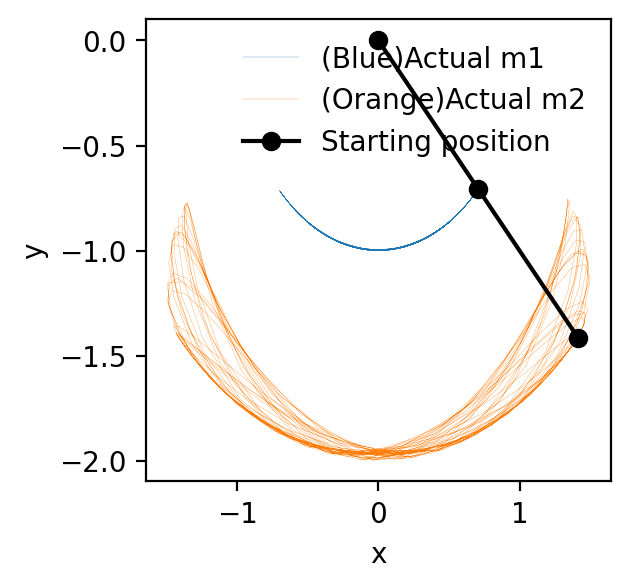

In [6]:
#solving for initial conditions
x1, y1, x2, y2 = Solve_Actual(tmax, z0, t, L1,L2,m1,m2)

#plotting solutions
fig,ax=plt.subplots(figsize=(3,3))
ax.plot(x1, y1,"-", label="(Blue)Actual m1", linewidth=0.1)
ax.plot(x2, y2,"-", label="(Orange)Actual m2", linewidth=0.1)
#plot starting positions 
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Starting position", c='k')
plt.ylabel("y")
plt.xlabel("x")
ax.legend()

# Exercises: Predicting Chaos
1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$. 
2. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp
3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)
4. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.
5. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)



## Part 1 

In [7]:
#defining model
model=keras.models.Sequential([
    keras.layers.LSTM(16, input_shape=(None, 4)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(4, activation='linear'),])

#compile model
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                1344      
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 64)                1088      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 6852 (26.77 KB)
Trainable params: 6852 (26.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
#defining train/test split
upper = int(0.7*len(y1))

#make array for training and testing with a 70/30 split
data_test=np.column_stack((x1[upper:-1], y1[upper:-1],x2[upper:-1], y2[upper:-1])).T
data_train=np.column_stack((x1[0:upper], y1[0:upper], x2[0:upper], y2[0:upper])).T

print(data_train.shape)

(4, 350)


In [9]:
def window_gen(dataset, offset, windowsize):
    """
    Generate windows of data and corresponding labels from a dataset.

    Parameters:
        dataset:    The dataset from which windows are generated.
        offset:     The offset indicating the gap between each window and its corresponding label.
        windowsize: The size of each window.

    Returns:
        data:  Array of windows of data.
        label: Array of corresponding labels.
    """
    
    #empty arrays to append windows to
    data = []
    label = []

    # Iterate over the dataet to generate windows and labels
    for i in range(windowsize, len(dataset[0]) - offset):
        # extract a window of data
        window = dataset[:, i - windowsize:i]
        data.append(window)
        
        # Extract the next value l
        next_value = dataset[:, i + offset]
        label.append(next_value)
    
    #convert lists to numpy arrays
    data = np.array(data)
    label = np.array(label)
    
    return data, label

In [10]:
def train_model(model, train_in, train_lb, test_in, test_lb, steps):
    """
    Train a model using the given training and testing data.

    Parameters:
        model: The model to be trained.
        train_in: The input data for training.
        train_lb: The labels corresponding to the training input data.
        test_in: The input data for testing.
        test_lb: The labels corresponding to the testing input data.
        steps: Number of training steps.
    """
    
    # Compile the model to ensure untrained
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    costs = []
    
    # Iterate over the specified number of training steps
    for i in range(steps):
        #reshape training input data
        input_t = train_in.reshape(train_in.shape[0], windowsize, train_in.shape[1])
        #Train the model on a batch of trainng data
        cost = model.train_on_batch(input_t, train_lb)
        costs.append(cost)
        

        # Reshape testing input data
        input_test = test_in.reshape(test_in.shape[0], windowsize, test_in.shape[1])
        # Test the model on a batch of testing data
        model.test_on_batch(input_test, test_lb)
    
    print("Training cost =",costs[-1])
    

    return


In [19]:
#Initial paramters 
steps=1000
windowsize=30
offset=20


#Get data training and testiong data sets 
train_data, train_lb = window_gen(data_train,offset,windowsize)
test_data, test_lb = window_gen(data_test,offset,windowsize)

print(train_data.shape)


(300, 4, 30)


In [21]:

#calling train model function
costs1 = train_model(model, train_data, train_lb, test_data, test_lb, steps)

#reshgaping data
input_train = train_data.reshape(train_data.shape[0], windowsize, train_data.shape[1])
input_test = test_data.reshape(test_data.shape[0], windowsize, test_data.shape[1])

#predict on entire dataset
pred_train = model.predict(input_train)
pred_test = model.predict(input_test)

print(input_train.shape)

# Concatinate predictions
pred = np.concatenate((pred_train, pred_test), axis=0)

print(pred.train)

Training cost = 0.0005284575745463371
4/4 [==============================] - 0s 5ms/step
(300, 30, 4)


AttributeError: 'numpy.ndarray' object has no attribute 'train'

In [17]:
print(pred_train.shape)

print(input_train.shape)

(300, 4)
(300, 30, 4)


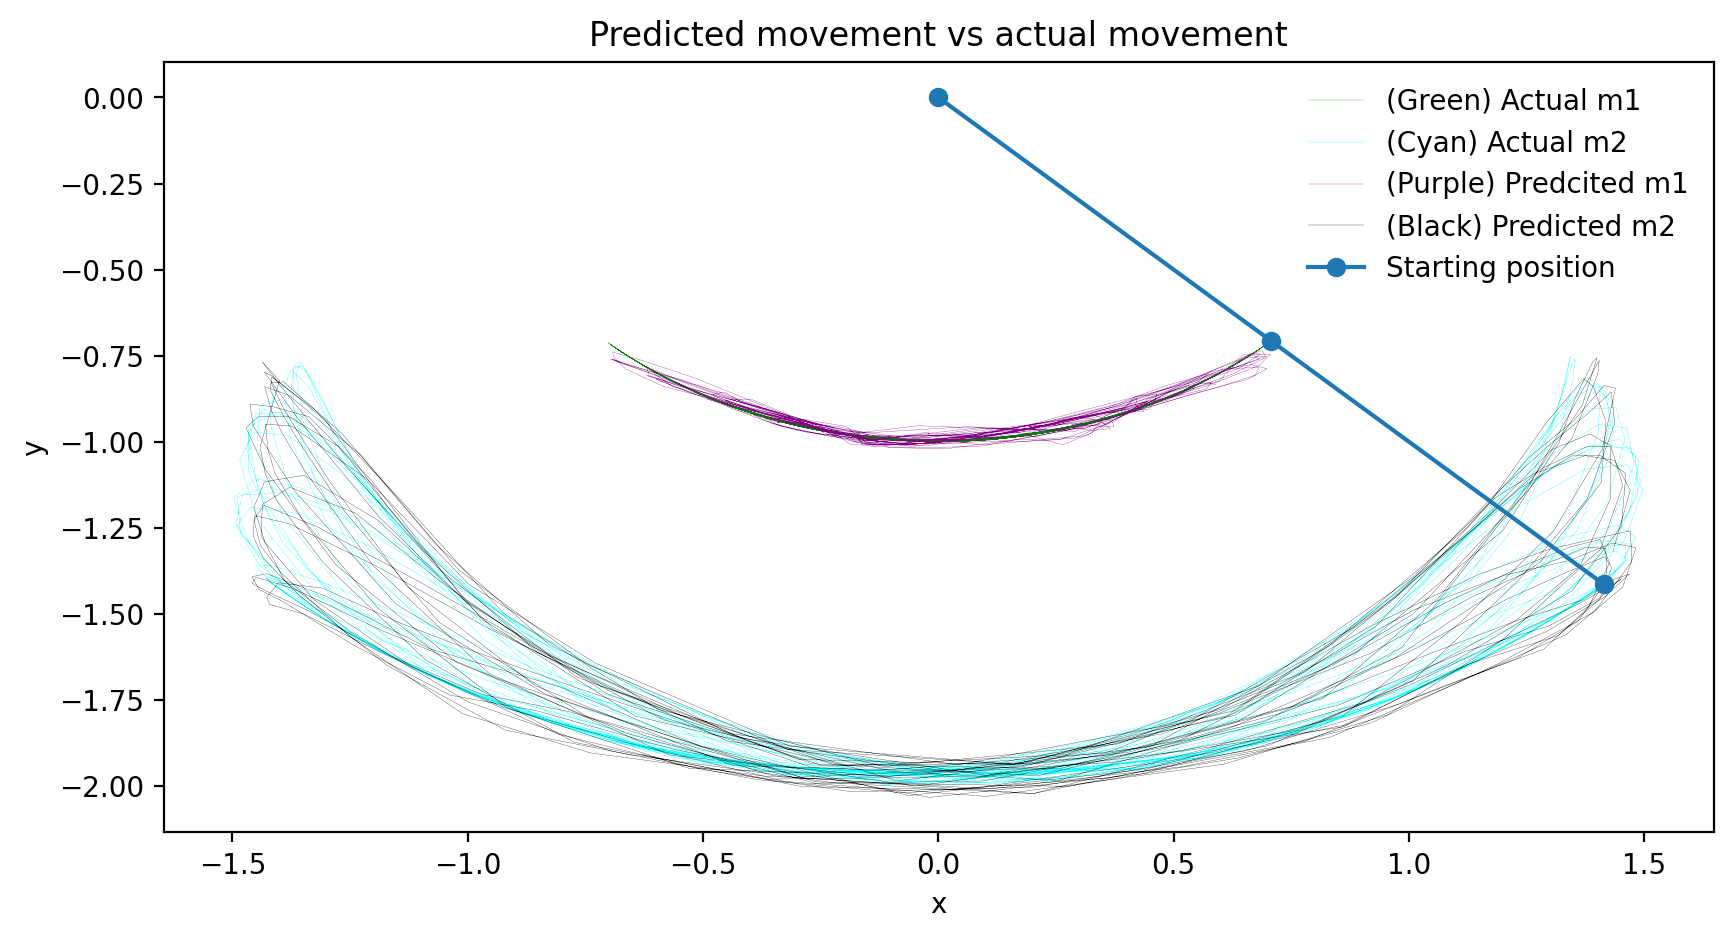

In [13]:
def plot_pred(steps,x1pred, y1pred, x2pred, y2pred,x1, x2, y1, y2):
    
    """
    Plot values obtained from train_model function
    Parameters:
        x1pred: predicted value from train_model
        x2pred: predicted value from train_model
        y1pred: predicted value from train_model
        y2pred: predicted value from train_model
        x1,x2,y1,y2: Analytical solutions from Solve_actual function
        steps: Number of training steps.
    """
    
    
    #Set figure size
    fig,ax=plt.subplots(1, figsize=(10,5))
    
    #Plot of original model
    plt.plot(x1, y1, label="(Green) Actual m1",c='green', linewidth=0.1)
    plt.plot(x2, y2, label="(Cyan) Actual m2",c='cyan', linewidth=0.1)
    
    #Plot of model prediction
    plt.plot(x1pred, y1pred, label=r"(Purple) Predcited m1",c ='purple', linewidth=0.1)
    plt.plot(x2pred, y2pred, label=r"(Black) Predicted m2",c = 'black', linewidth=0.1)
    #plot starting positions
    plt.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Starting position")
    
    #Plot labels and title
    plt.ylabel("y")
    plt.xlabel("x")
    plt.title("Predicted movement vs actual movement")
    plt.legend()
    
    return
    
#calling function
plot_pred(steps, pred[:,0],pred[:,1],pred[:,2],pred[:,3],x1,x2,y1,y2)



   ### Comments
   
   We can see the model fails to predict exactly the motion of the pendulum however the path taken is very similar to the path predicted by the model. The model overall does a decent job at predicted the motion.

## Task 2


In [13]:
def plot_motion(pred, analytical, t, tlimit):
    """
    Plot the predicted displacement versus actual displacement against time

    Parameters:
        pred: Predicted motion data.
        analytical: Actual motion data.
        t: Time array.
        tlimit: Time limit for the plot.
    """
    # Set size and format
    fig, ax = plt.subplots(2, 2, figsize=(14, 5))
    plt.subplots_adjust(hspace=0.8)
    
    # Plot x1 over time
    ax[0, 0].plot(t, analytical[0], label=r"$x1_{True}$")
    # Plot prediction over time
    ax[0, 0].plot(t[(len(t) - len(pred[:, 0])):], pred[:, 0], label="model x1")
    ax[0, 0].set_xlabel('time')
    ax[0, 0].set_ylabel('x1')
    ax[0, 0].legend()
    ax[0, 0].set_title('Predicted motion vs actual motion')
    
    # Plot y1 over time
    ax[1, 0].plot(t, analytical[1], label="Actual x2")
    # Plot prediction over time
    ax[1, 0].plot(t[(len(t) - len(pred[:, 2])):], pred[:, 2], label=r"model x2")
    ax[1, 0].set_xlabel('time')
    ax[1, 0].set_ylabel('x2')
    ax[1, 0].legend()
    ax[1, 0].set_title('Predicted motion vs actual motion')
    
    # Plot x2 over time
    ax[0, 1].plot(t, analytical[2], label="Actual x1")
    # Plot prediction over time
    ax[0, 1].plot(t[(len(t) - len(pred[:, 1])):], pred[:, 1], label="model y1")

    ax[0, 1].set_xlabel('time')
    ax[0, 1].set_ylabel('y1')
    ax[0, 1].legend()
    ax[0, 1].set_title('Predicted motion vs actual motion')
    
    # Plot y2 over time
    ax[1, 1].plot(t, analytical[3], label="Actual y2")
    # Plot prediction over time
    ax[1, 1].plot(t[(len(t) - len(pred[:, 0])):], pred[:, 3], label="model y2")
    ax[1, 1].set_xlabel('time')
    ax[1, 1].set_ylabel('y2')
    ax[1, 1].legend()
    ax[1, 1].set_title('Predicted motion vs actual motion')

    return




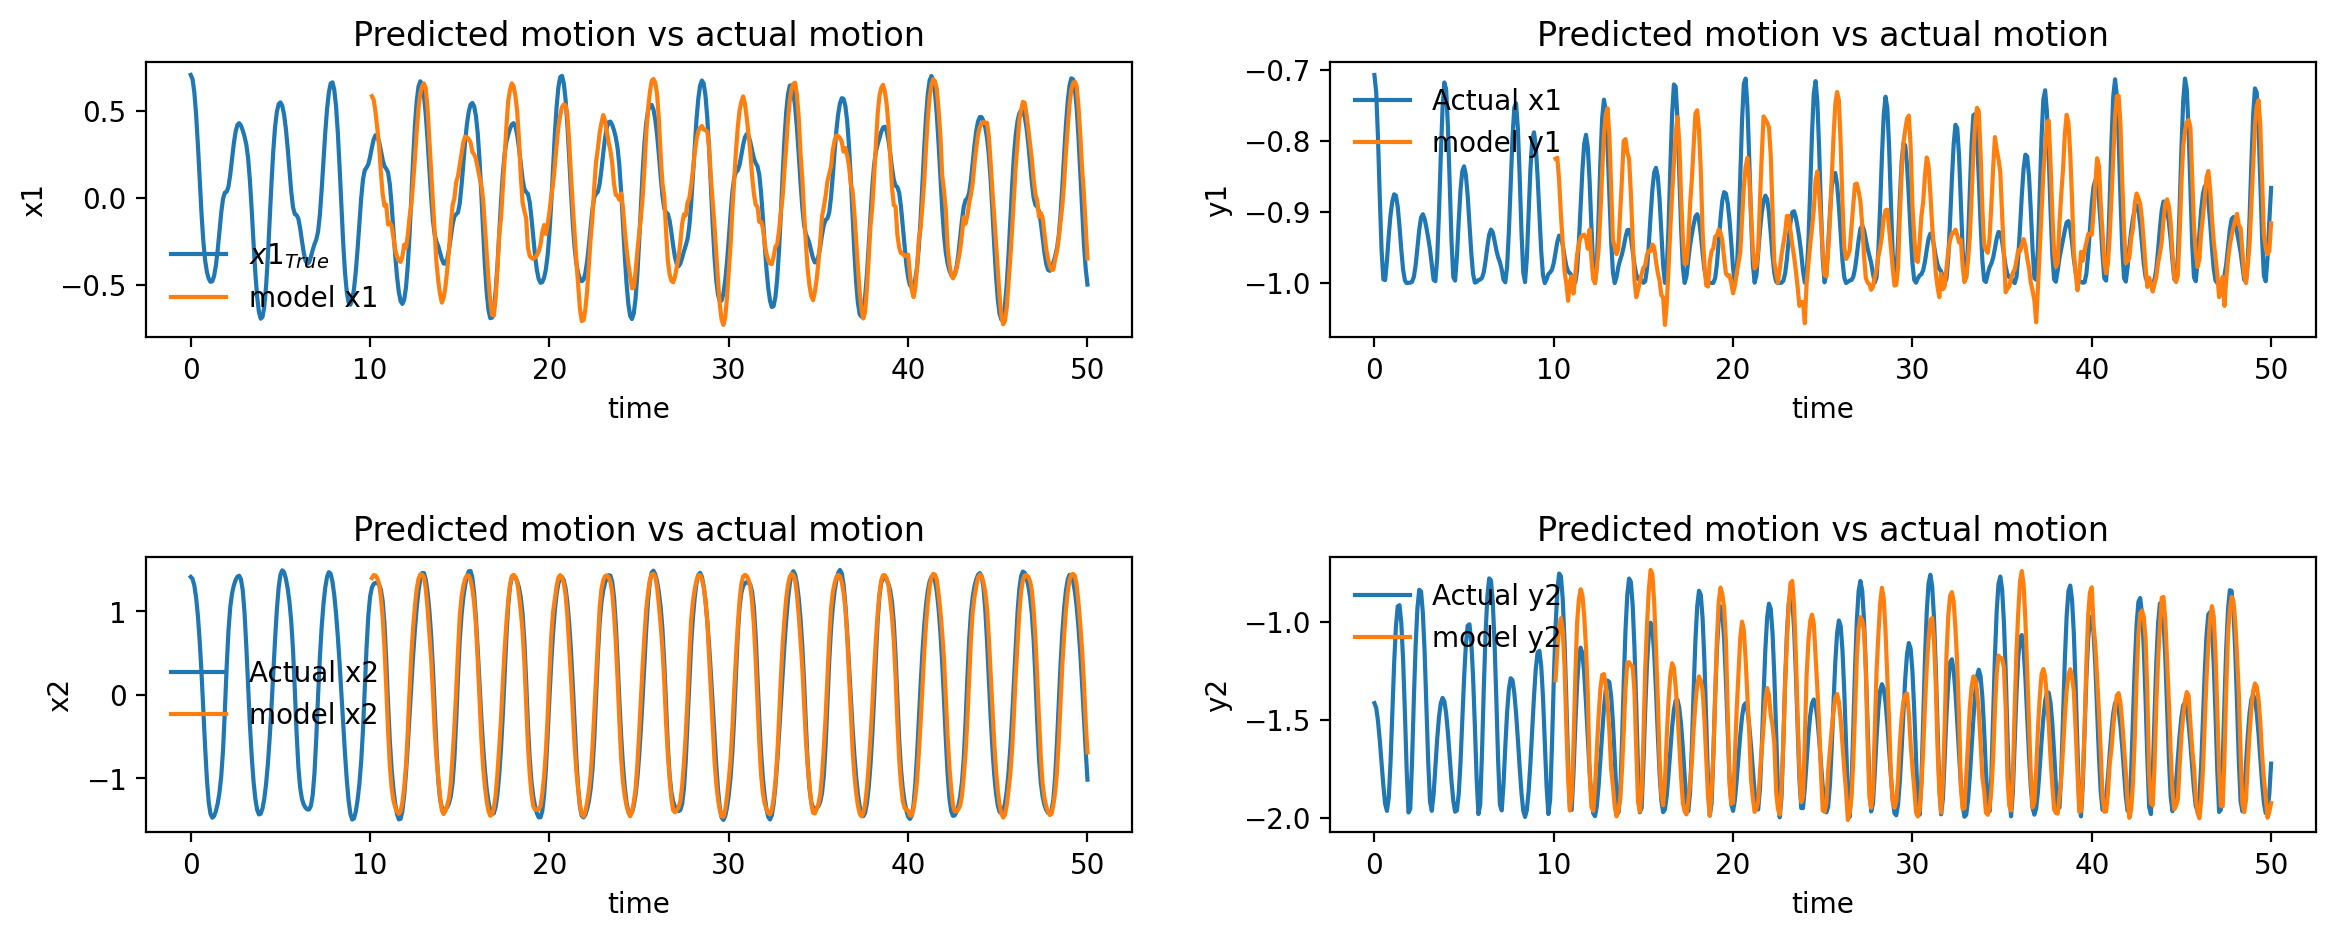

In [14]:
#paramters to be used 
x1, y1, x2, y2 = Solve_Actual(tmax, z0, t, L1,L2,m1,m2)
val=(x1,x2,y1,y2)
tmax2=(0,50)

#calling plot_motion function
plot_motion(pred, val,t,tmax2)


### Comments

The predicted motion mirrors the closely the actual motion but deviations are visible, particularly on the y parameters, that exhibit a slight phase shift, which is expected since the y range is more suseptible to chaotic motion.

## Task 3


In [15]:
def train_offsets(z0, offsets, windowsize, model):
    """
    Train the model with different offsets and evaluate its performance using evaluate 

    Parameters:
        z0: Initial angle conditions for the pendulum system.
        offsets: List of offsets to iterate through.
        windowsize: The size of each window.
        model: The model to train and evaluate.

    Returns:
        deviation: List of deviations for each offset by evaluating the model
    """

    # Solve the actual motion of the pendulum
    x12, y12, x22, y22 = Solve_Actual(tmax, z0, t, L1, L2, m1, m2)

    # Separate data into test and train batches (70/30 split)
    upper2 = int(0.7 * len(x12))
    data_test_2 = np.column_stack((x12[upper2:-1], y12[upper2:-1], x22[upper2:-1], y22[upper2:-1])).T
    data_train_2 = np.column_stack((x12[0:upper2], y12[0:upper2], x22[0:upper2], y22[0:upper2])).T
    
    # Empty array to append deviations to
    deviation = []

    # Loop over all offsets
    for i in range(len(offsets)):
        # Generate windows and labels for training and testing data
        train_in_2, train_lb_2 = window_gen(data_train_2, offsets[i], windowsize)
        test_in_2, test_lb_2 = window_gen(data_test_2, offsets[i], windowsize)
        
        # train the model with the current offset
        train_model(model, train_in_2, train_lb_2, test_in_2, test_lb_2, 1000)
        
        #reshape test input for evaluation
        rs_test = test_in_2.reshape(test_in_2.shape[0], windowsize, test_in_2.shape[1])
        
        #Evaluate the model on the test data
        test_dev = model.evaluate(rs_test, test_lb_2 , verbose=1)
        
        # Append the deviation to the list
        deviation.append(test_dev)
        
    return deviation

In [16]:
#defining offsets
offset_2=np.arange(20,101,5)
#calling train_offset functions
dev2=train_offsets(z0,offset_2,windowsize, model)





Training cost = 0.0005757589242421091
4/4 [==============================] - 0s 4ms/step - loss: 6.5026e-04
Training cost = 0.0024893658701330423
3/3 [==============================] - 0s 4ms/step - loss: 0.0024
Training cost = 0.0009007401531562209
3/3 [==============================] - 0s 4ms/step - loss: 8.4955e-04
Training cost = 0.0009582549682818353
3/3 [==============================] - 0s 5ms/step - loss: 0.0010
Training cost = 0.0014841583324596286
3/3 [==============================] - 0s 5ms/step - loss: 0.0013
Training cost = 0.0011087992461398244
3/3 [==============================] - 0s 4ms/step - loss: 0.0012
Training cost = 0.0008725084480829537
3/3 [==============================] - 1s 4ms/step - loss: 0.0011
Training cost = 0.0018333253683522344
3/3 [==============================] - 0s 9ms/step - loss: 0.0020
Training cost = 0.0017482294933870435
2/2 [==============================] - 0s 5ms/step - loss: 0.0018
Training cost = 0.0020013824105262756
2/2 [=============

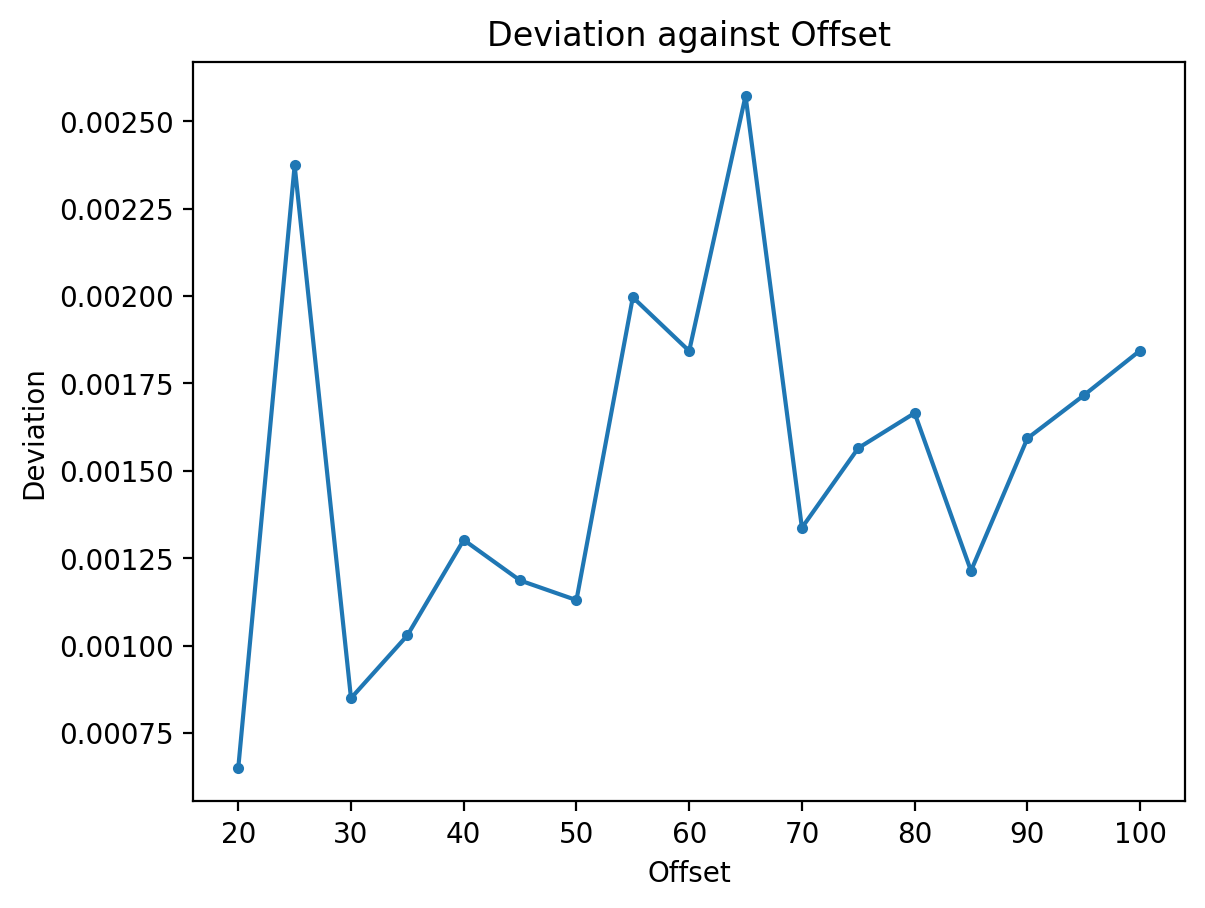

In [17]:
#Plot the loss over the different offsets
plt.figure()
plt.plot(np.arange(20,101,5), dev2, '.-')
plt.xlabel("Offset")
plt.ylabel("Deviation")
plt.title("Deviation against Offset")
plt.show()

### Comments
There is a slight trend showing that as offset increases the deviation increases which is to be expected from a chaotic system however the deviation is low since the system is quite easily modelled.

## Task 4


In [18]:
#updated initial paramters

#starting angles
z1=[np.pi/2,0,np.pi/2,0]

#lengths, masses and gravity constant
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81    

#time data
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

#analytically solving for updated parameters
x11, y11, x21, y21 = Solve_Actual(tmax, z1, t, L1,L2,m1,m2)



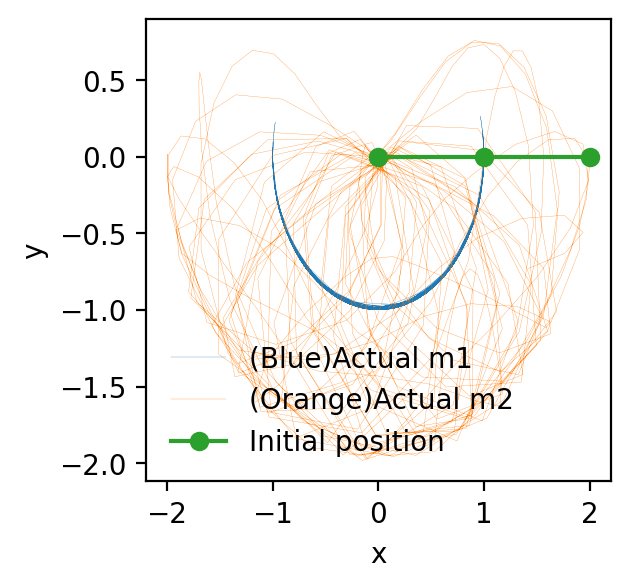

In [19]:
#actual plot of double pendulum analytically solved using Solve_actual function
fig,ax=plt.subplots(figsize=(3,3))
ax.plot(x11, y11,"-", label="(Blue)Actual m1", linewidth=0.1)
ax.plot(x21, y21,"-", label="(Orange)Actual m2", linewidth=0.1)
ax.plot([0, x11[0], x21[0]], [0, y11[0], y21[0]], "-o", label="Initial position")
plt.ylabel("y")
plt.xlabel("x")
ax.legend()

In [20]:
#defining a new model

model2=keras.models.Sequential([
    keras.layers.LSTM(16, input_shape=(None, 4)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(4, activation='linear'),])

#compile model
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 16)                1344      
                                                                 
 flatten_1 (Flatten)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                1088      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 6852 (26.77 KB)
Trainable params: 6852 (26.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
#defining train/test split
upper = int(0.7*len(y11))

#make array for training and testing with a 70/30 split
data_test2=np.column_stack((x11[upper:-1], y11[upper:-1],x21[upper:-1], y21[upper:-1])).T
data_train2=np.column_stack((x11[0:upper], y11[0:upper], x21[0:upper], y21[0:upper])).T

In [22]:
#initial parameters
steps=1000
windowsize=30
offset=20


#Get data training and testiong data sets 
train_data2, train_lb2 = window_gen(data_train2,offset,windowsize)
test_data2, test_lb2 = window_gen(data_test2,offset,windowsize)

In [23]:
#training model using model 2 
train_model(model2, train_data2, train_lb2, test_data2, test_lb2, steps)

#reshaping output data
input_train2 = train_data2.reshape(train_data2.shape[0], windowsize, train_data2.shape[1])
input_test2 = test_data2.reshape(test_data2.shape[0], windowsize, test_data2.shape[1])

#predicting on entire dataset with trained model
pred_train2 = model2.predict(input_train2)
pred_test2 = model2.predict(input_test2)

# Concatinating predictions
pred_2 = np.concatenate((pred_train2, pred_test2), axis=0)

Training cost = 0.02500242553651333
4/4 [==============================] - 0s 2ms/step


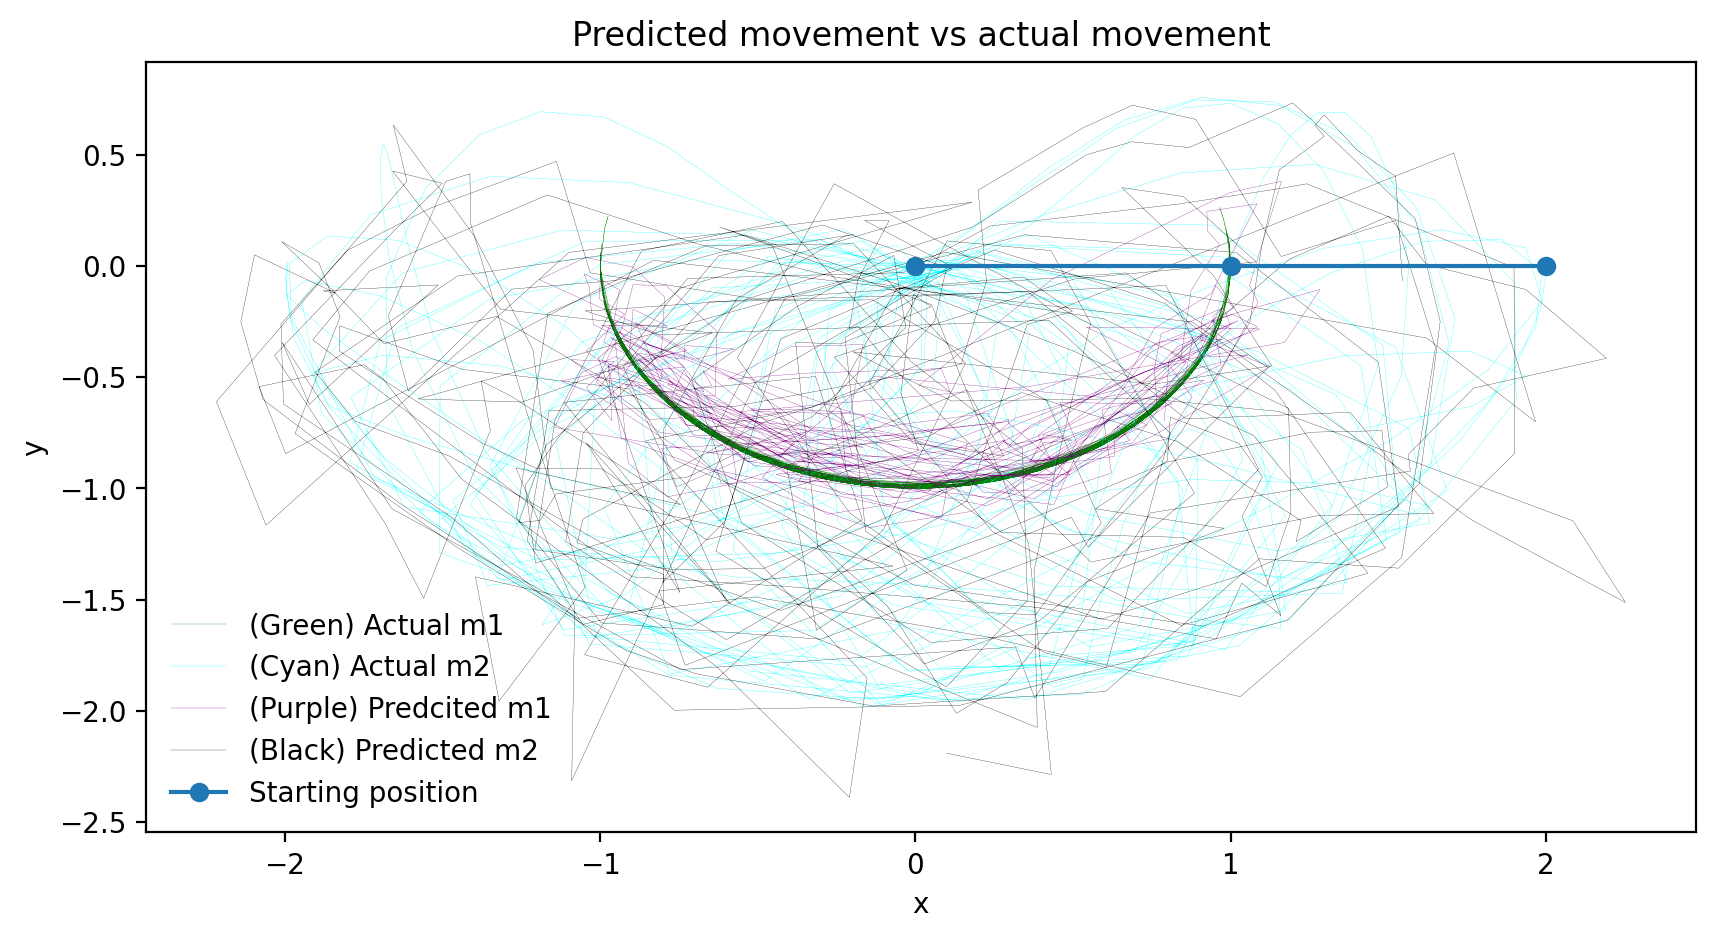

In [24]:
#plot predicted motion against analytically solved motion
plot_pred(steps, pred_2[:,0],pred_2[:,1],pred_2[:,2],pred_2[:,3],x11,x21,y11, y21)



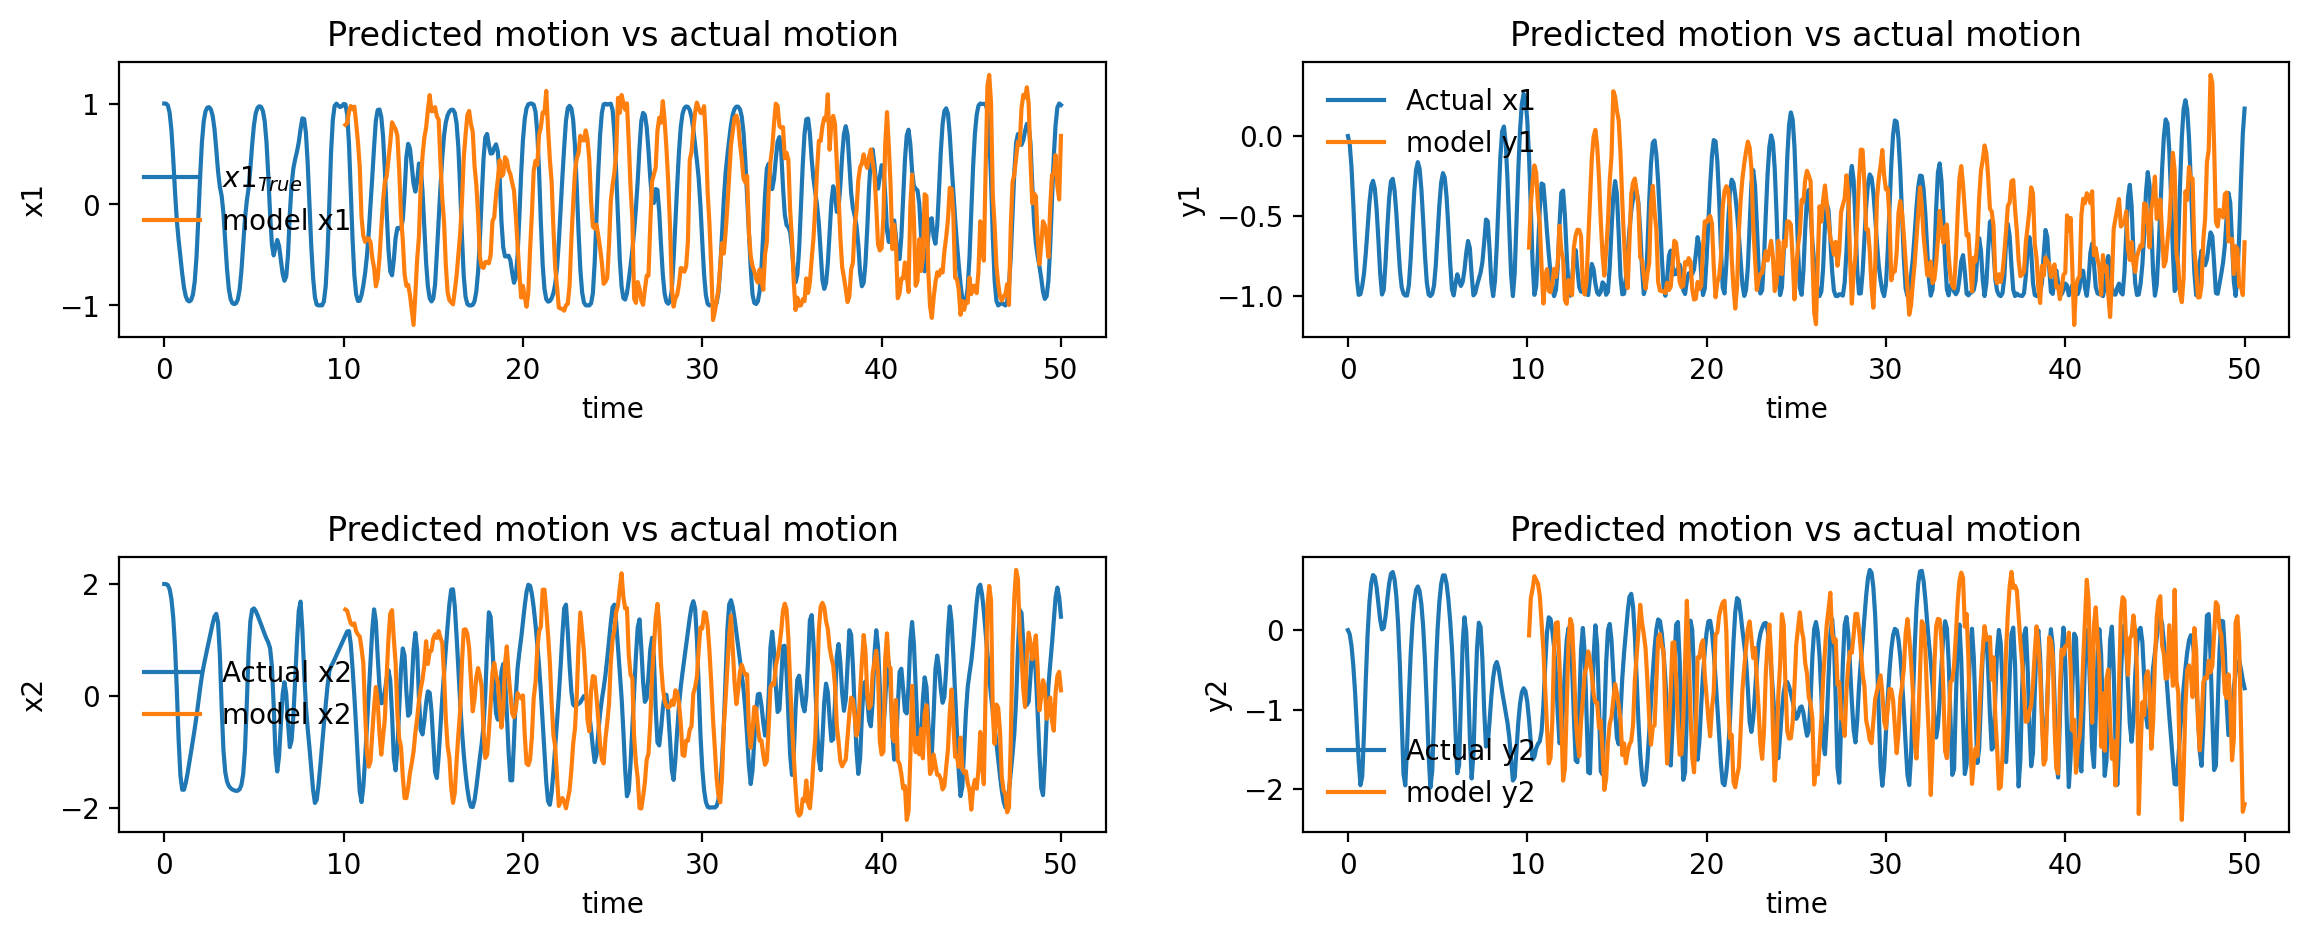

In [25]:
#time parameters
tmax2=(0,50)
#analytically solved motion
val2 = (x11,x21,y11,y21)

#Plot x and y over time Original vs Predicted
plot_motion(pred_2, val2,t,tmax2)

### Comments
It is clear to see that the model fails to predict the motion of the pendulum with the changed starting conditions. The model suggests the masses leave the range of the pendulum, which is obviously physically impossible. The slight change in initial conditions proves very difficult for the network to model and thus leading to an inaccurate prediction of the motion. 

In [26]:
#loss vs offset

offset_2=np.arange(20,101,5)
#Get loss of training over the different offsets
dev3=train_offsets(z1,offset_2,windowsize,model2)

Training cost = 0.013660167343914509
4/4 [==============================] - 0s 4ms/step - loss: 0.8903
Training cost = 0.03918514400720596
3/3 [==============================] - 1s 6ms/step - loss: 0.8687
Training cost = 0.0584774985909462
3/3 [==============================] - 1s 6ms/step - loss: 0.9319
Training cost = 0.07207106798887253
3/3 [==============================] - 1s 5ms/step - loss: 0.7650
Training cost = 0.0693431943655014
3/3 [==============================] - 1s 5ms/step - loss: 0.8026
Training cost = 0.053702909499406815
3/3 [==============================] - 0s 4ms/step - loss: 0.7299
Training cost = 0.04756486415863037
3/3 [==============================] - 1s 4ms/step - loss: 1.3956
Training cost = 0.0452197790145874
3/3 [==============================] - 1s 4ms/step - loss: 1.1542
Training cost = 0.0397898405790329
2/2 [==============================] - 1s 13ms/step - loss: 1.4699
Training cost = 0.05776767432689667
2/2 [==============================] - 1s 5ms/s

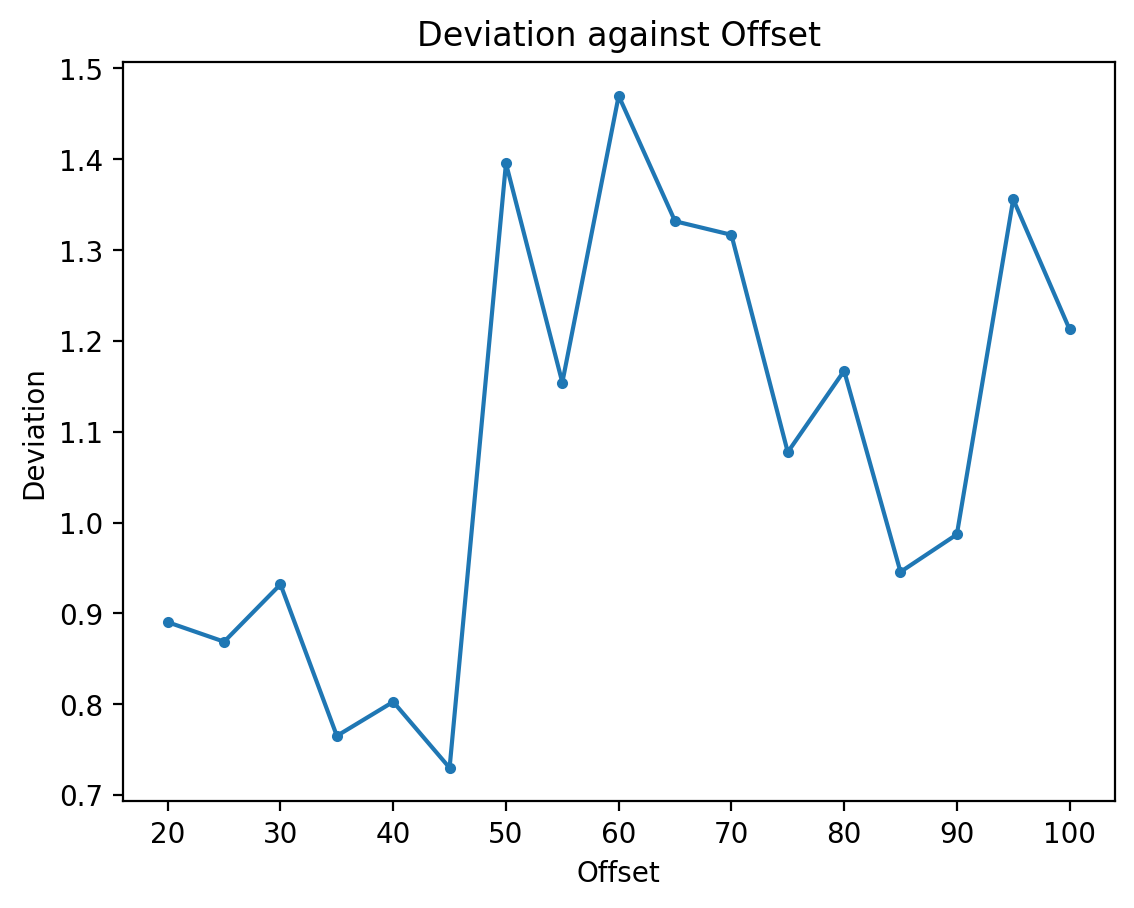

In [27]:
#Plot the loss over the different offsets
plt.figure()
plt.plot(np.arange(20,101,5), dev3, '.-')
plt.xlabel("Offset")
plt.ylabel("Deviation")
plt.title("Deviation against Offset")
plt.show()

### Comments
We can see that as the offset increases the deviation increases. This is expected as the highly chaotic system means that the further ahead the prediction, the more uncertain the motion is. The large deviation is indictitive of the network failing to accuratly model the motion. 

## Task 5


In [50]:
#analytical system and initial paramters
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     

#initisal angles
z0=[np.pi/4,0,np.pi/4,0]
z1=[np.pi/2,0,np.pi/2,0]

#time parameters
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

steps=1000
windowsize=30
offset=20

#analytically solved system using parameters above
x13, y13, x23, y23 = Solve_Actual(tmax, z0, t, L1,L2,m1,m2)


In [63]:
#new model for task 5

model3=keras.models.Sequential([
    keras.layers.LSTM(16, input_shape=(None, 4)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(4, activation='linear'),])

#compile model
model3.compile(loss='mean_squared_error', optimizer='adam')
model3.summary()



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 16)                1344      
                                                                 
 flatten_6 (Flatten)         (None, 16)                0         
                                                                 
 dense_18 (Dense)            (None, 64)                1088      
                                                                 
 dense_19 (Dense)            (None, 64)                4160      
                                                                 
 dense_20 (Dense)            (None, 4)                 260       
                                                                 
Total params: 6852 (26.77 KB)
Trainable params: 6852 (26.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
#splitting data train/test 70/30
upper = int(0.7*len(y1))

#make array for training and testing with a 70/30 split
data_test3=np.column_stack((x13[upper:-1], y13[upper:-1],x23[upper:-1], y23[upper:-1])).T
data_train3=np.column_stack((x23[0:upper], y23[0:upper],np.zeros(len(y13[0:upper])), np.zeros(len(y13[0:upper])) )).T

data_test32=np.column_stack((x13[0:upper], y13[0:upper],x23[0:upper], y23[0:upper] )).T



In [67]:
#Get data training and testing data sets 
train_data3, train_lb3 = window_gen(data_train3,offset,windowsize)
test_data3, test_lb3 = window_gen(data_test3,offset,windowsize)
test_data32, testlbl32 = window_gen(data_test32,offset,windowsize)

In [68]:
#training model on analytical parameters 
train_model(model3, train_data3, train_lb3, test_data3, test_lb3, steps)

#reshaping data
input_train3 = train_data3.reshape(train_data3.shape[0], windowsize, train_data3.shape[1])
input_test3 = test_data3.reshape(test_data3.shape[0], windowsize, test_data3.shape[1])
input_test32 = test_data32.reshape(test_data32.shape[0], windowsize, test_data32.shape[1])


#predicting on all data
pred_train3 = model3.predict(input_test32)
pred_test3 = model3.predict(input_test3)

#concatonating predictions
pred3 = np.concatenate((pred_train3, pred_test3), axis=0)

Training cost = 0.001943699549883604
4/4 [==============================] - 0s 4ms/step


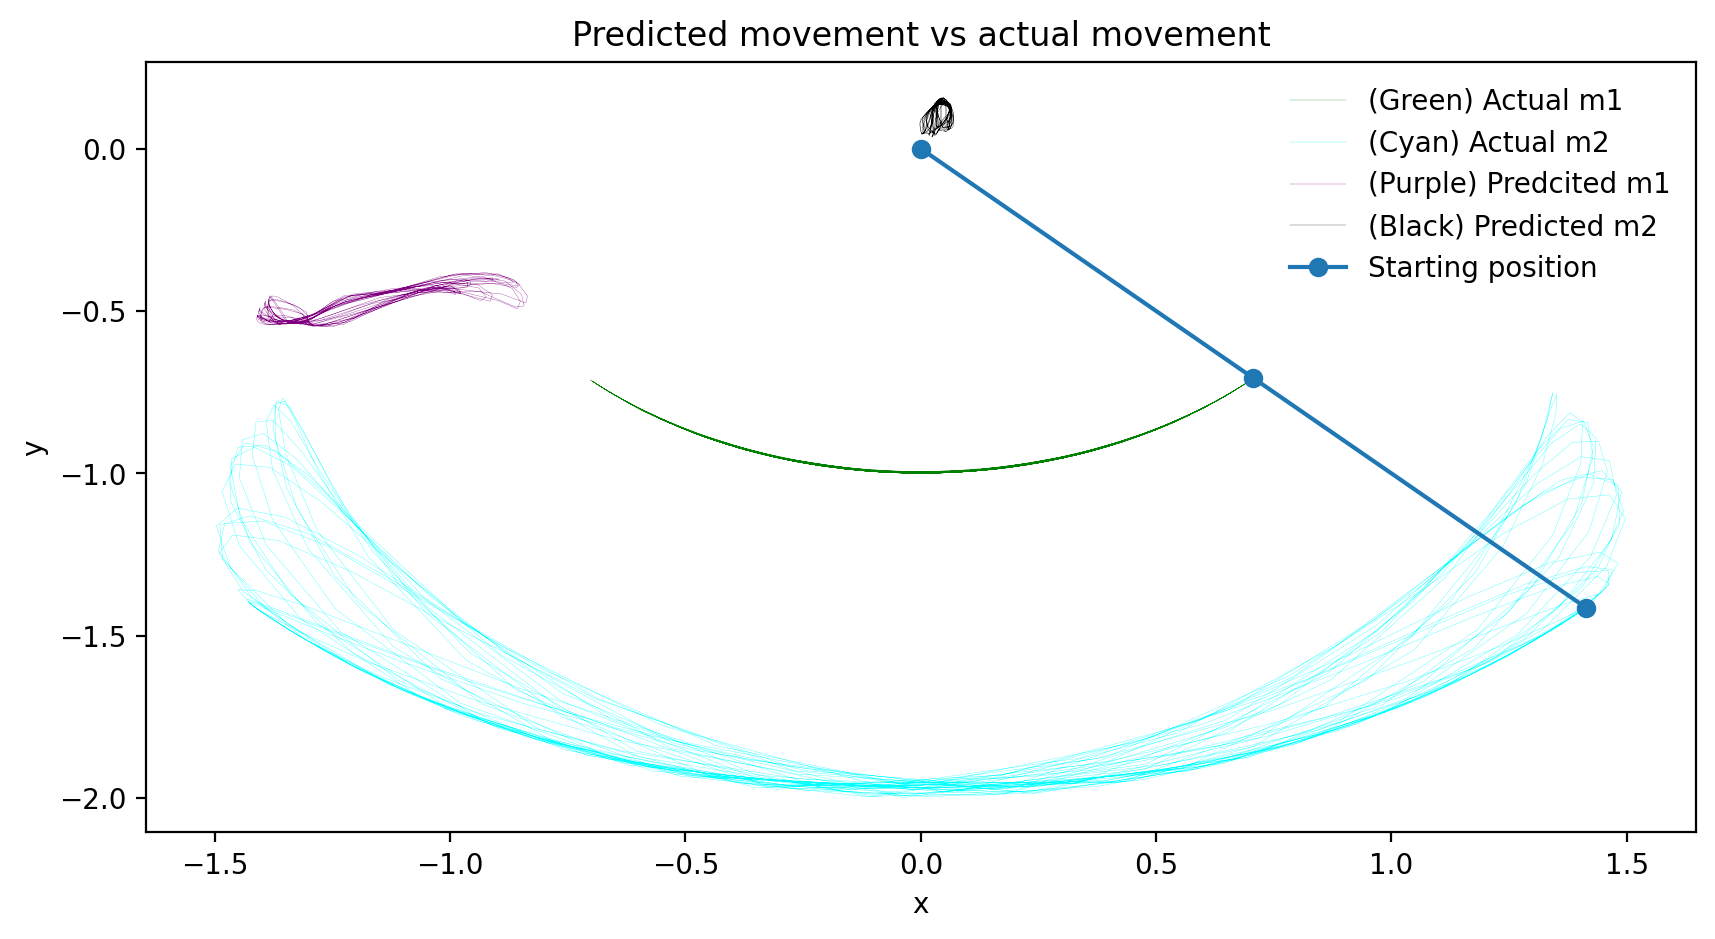

In [72]:
#plotting predictions against actual
plot_pred(steps, pred3[:,0],pred3[:,1],pred3[:,2],pred3[:,3],x13,x23,y13, y23)

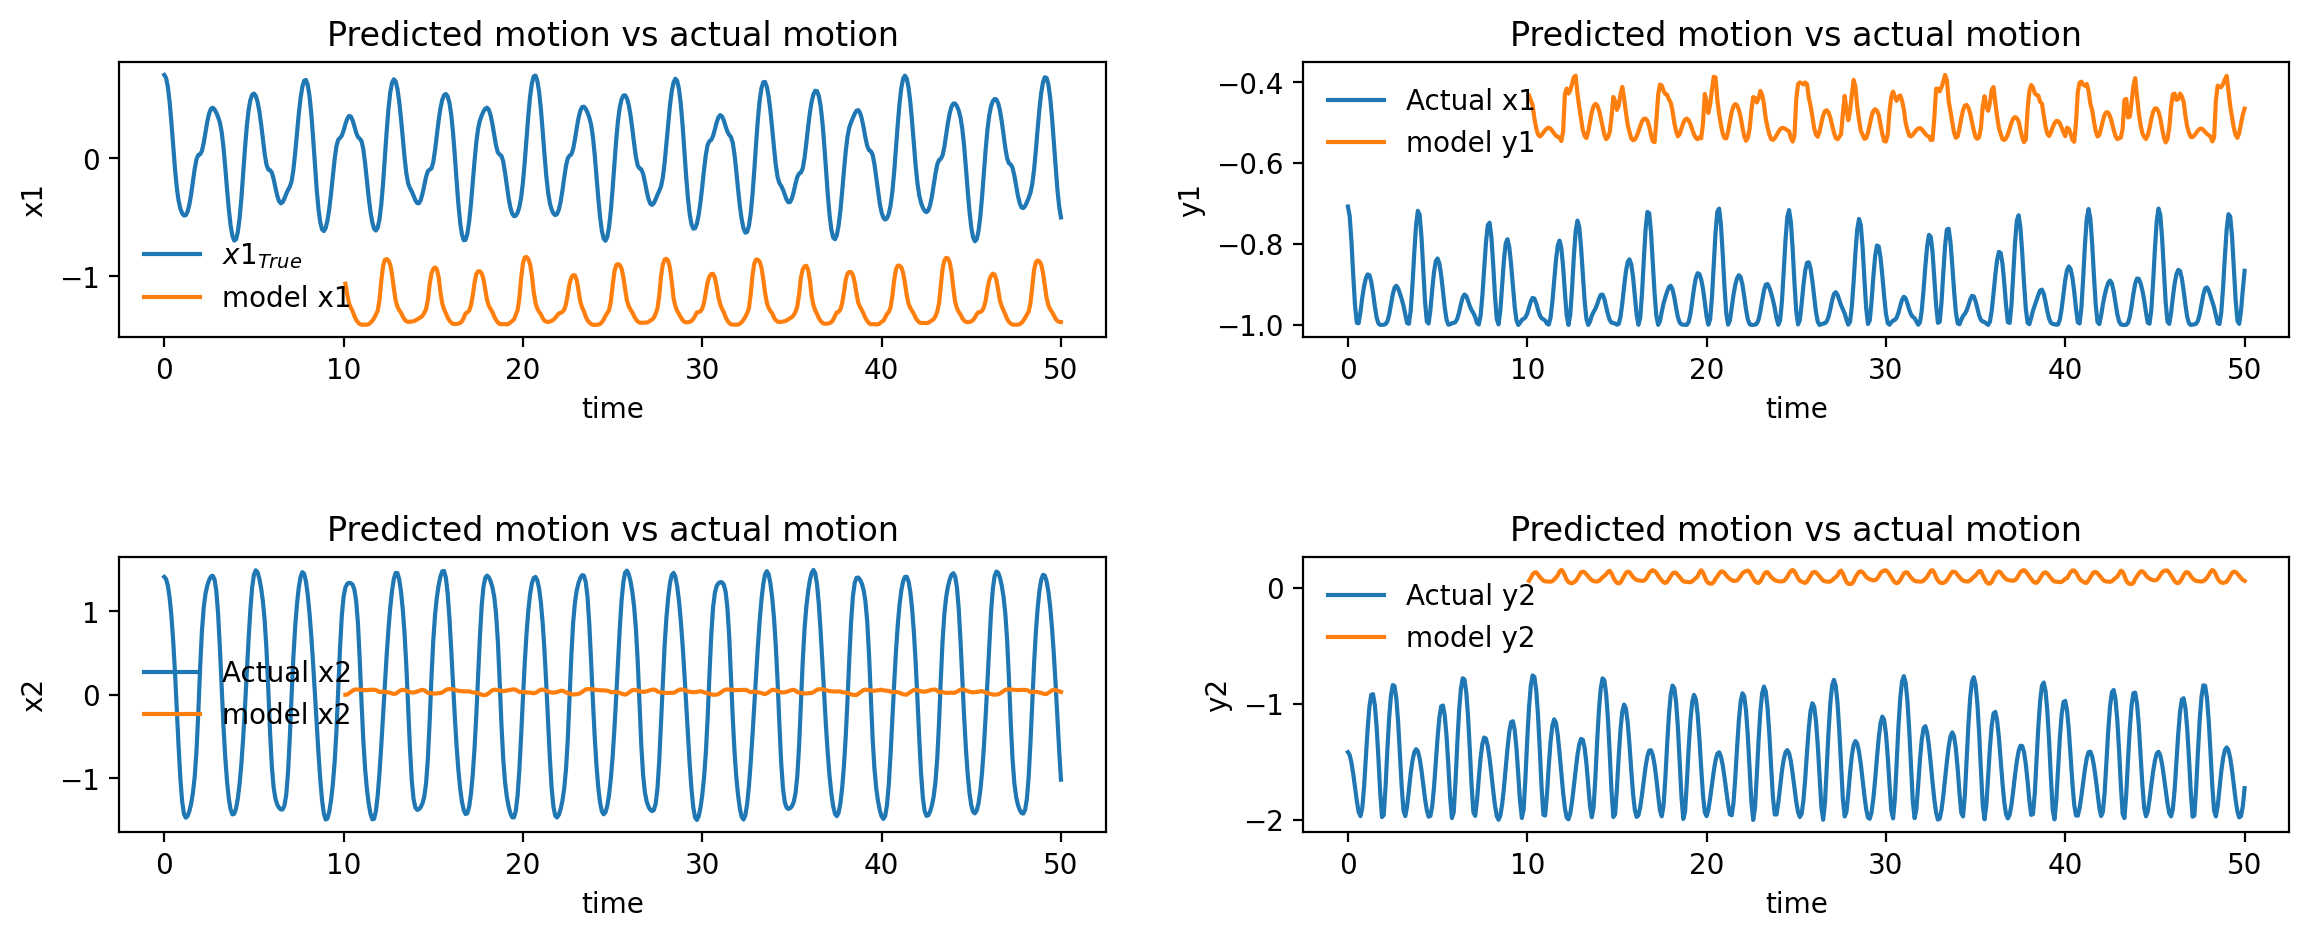

In [70]:
tmax2=(0,50)

val3 = (x13,x23,y13,y23)

#Plot x and y over time Original vs Predicted
plot_motion(pred3, val3,t,tmax2)

### Comments
The model struggles to predict the motion of m1 without being trained on it. It picks up on the periodicity however the values are very wrong. The m2 values are accurate since the model was trained on this.

In [ ]:
offset_3=np.arange(20,101,5)
#Get loss of training over the different offsets
dev4=train_offsets(z0,offset_2,windowsize, model3)

Training cost = 0.001462843851186335
4/4 [==============================] - 2s 19ms/step - loss: 0.0013
Training cost = 0.0012828357284888625
3/3 [==============================] - 2s 6ms/step - loss: 0.0014
Training cost = 0.000947168271522969
3/3 [==============================] - 1s 6ms/step - loss: 8.7889e-04
Training cost = 0.0007700868882238865
3/3 [==============================] - 2s 6ms/step - loss: 9.2364e-04
Training cost = 0.0016787053318694234
3/3 [==============================] - 2s 6ms/step - loss: 0.0016
Training cost = 0.0015495765255764127
3/3 [==============================] - 2s 7ms/step - loss: 0.0017
Training cost = 0.0013709133490920067
3/3 [==============================] - 2s 7ms/step - loss: 0.0018
Training cost = 0.0012560052564367652
3/3 [==============================] - 2s 13ms/step - loss: 0.0018


In [ ]:
#Plot the loss over the different offsets
plt.figure()
plt.plot(np.arange(20,101,5), dev4, '.-')
plt.xlabel("Offset")
plt.ylabel("Loss")
plt.title("Loss against Offset")
plt.show()

### Comments